In [1]:
# import numpy and pandas
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%config Completer.use_jedi=False
import os

#import sklearn for cross validation|
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score,cross_validate

#import keras modules
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import keras.backend.tensorflow_backend as KTF
import keras
import keras.layers
from keras.layers import Layer 
import keras.initializers
from keras.models import Model, Sequential,load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Embedding, Lambda, Flatten, Multiply, multiply,dot, add,subtract
from keras.layers import Concatenate,concatenate,LeakyReLU,maximum,minimum
from keras.optimizers import Adam
from keras.regularizers import l2,l1
from keras.preprocessing import sequence
from keras.engine.topology import Layer, InputSpec

from keras.utils import plot_model
from IPython.display import SVG


from sklearn.metrics import precision_recall_curve, auc, roc_curve

#import rdkit
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols

#fix the random seed
np.random.seed(5)

import pickle
import random



Using TensorFlow backend.


In [2]:
GeneExpression_with_Symbol=pd.read_csv('/DAS_Storage4/ijjin/Study_2/CellLine/CCLE_expression_zscore.csv',index_col=0)
valid_gene_list=GeneExpression_with_Symbol.columns

In [3]:
GeneSet_List=[]
GeneSetFile='/DAS_Storage1/ijjin/Personal_studies/Drug-Cancer_reponse/geneset/c2.cp.kegg.v7.5.1.symbols.gmt'
with open(GeneSetFile) as f:
    reader = csv.reader(f)
    data = list(list(rec) for rec in csv.reader(f, delimiter='\t')) #reads csv into a list of lists
    for row in data:
        GeneSet_List.append(row)

GeneSet_Dic={}
for GeneSet in GeneSet_List:
    GeneSet_Dic[GeneSet[0]]=GeneSet[2:]
GeneSet_Dic_withoutNA={}
for GeneSet in GeneSet_Dic:
    GeneSet_tmp=pd.Series(GeneSet_Dic[GeneSet])
    GeneSet_tmp=GeneSet_tmp[GeneSet_tmp.isin(valid_gene_list)]
    GeneSet_Dic_withoutNA[GeneSet]=GeneSet_tmp




In [4]:
NCI60=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/221031_NCI60_median_with_raw_parameter.csv',index_col=0)

In [5]:
NCI60

,NSC,CellName,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope
0,1,786O,-2.0,1.916247,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
1,1,786O,-1.0,2.006393,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
2,1,786O,0.0,2.069248,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
3,1,786O,1.0,2.066457,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
4,1,786O,2.0,0.079399,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
...,...,...,...,...,...,...,...,...,...,...
4737369,783538,UACC62,-4.0,1.966015,2.040921,5,2.042580,3.025320e-01,-1.727939,2.277316
4737370,783538,UACC62,-3.0,2.040921,2.040921,5,2.042580,3.025320e-01,-1.727939,2.277316
4737371,783538,UACC62,-2.0,1.398113,2.040921,5,2.042580,3.025320e-01,-1.727939,2.277316
4737372,783538,UACC62,-1.0,0.613998,2.040921,5,2.042580,3.025320e-01,-1.727939,2.277316


In [6]:
NCI60_randomized=NCI60.sample(frac=1)
NCI60_randomized=NCI60_randomized.reset_index(drop=True)

<AxesSubplot:xlabel='AVERAGE_GIPRCNT', ylabel='Density'>

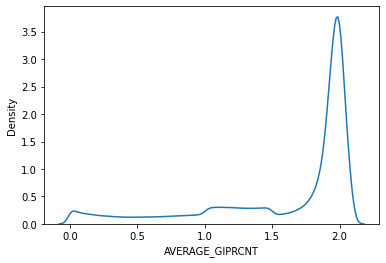

In [7]:
sns.kdeplot(NCI60_randomized.AVERAGE_GIPRCNT)

In [8]:
NCI60_randomized_level_list=[]
scale=0.1
for i in range(int(2/scale)):
    NCI60_randomized_level_df=NCI60_randomized[(NCI60_randomized.AVERAGE_GIPRCNT>i*scale)*(NCI60_randomized.AVERAGE_GIPRCNT<(i+1)*scale)]
    NCI60_randomized_level_list.append(NCI60_randomized_level_df)
len_min=min([len(df) for df in NCI60_randomized_level_list])
NCI60_randomized_level_list_new=[]
for df in NCI60_randomized_level_list:
    scale_each=len_min/len(df)
    df_new=df.sample(frac=scale_each)
    NCI60_randomized_level_list_new.append(df_new)
NCI60_balanced=pd.concat(NCI60_randomized_level_list_new)

<AxesSubplot:xlabel='AVERAGE_GIPRCNT', ylabel='Density'>

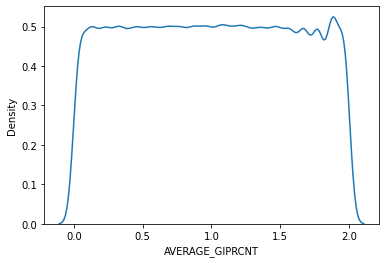

In [9]:
sns.kdeplot(NCI60_balanced.AVERAGE_GIPRCNT)

In [10]:
NCI60_randomized=NCI60_balanced.sample(frac=1)

NameError: name 'NCI60_balanced' is not defined

<AxesSubplot:xlabel='y_max', ylabel='Density'>

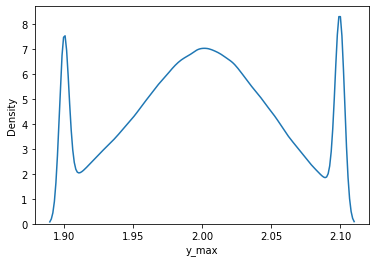

In [11]:
sns.kdeplot(NCI60_balanced.y_max)

<AxesSubplot:xlabel='y_min', ylabel='Density'>

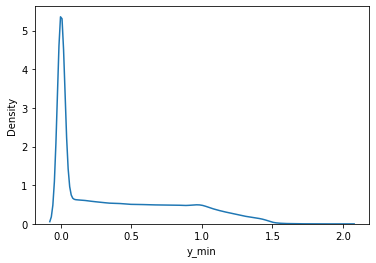

In [12]:
sns.kdeplot(NCI60_balanced.y_min)

<AxesSubplot:xlabel='IC50', ylabel='Density'>

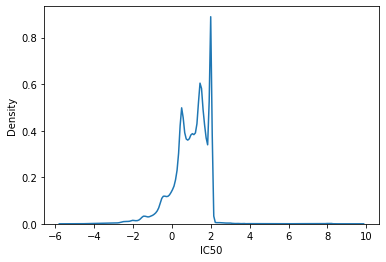

In [13]:
sns.kdeplot(NCI60_balanced.IC50)

<AxesSubplot:xlabel='slope', ylabel='Density'>

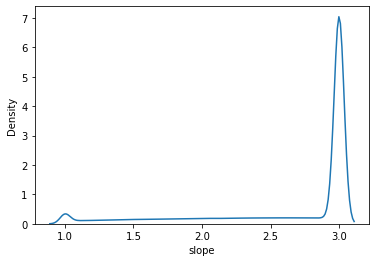

In [14]:
sns.kdeplot(NCI60_balanced.slope)

In [8]:
K.clear_session()
def get_session(gpu_fraction=0.1):

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    return tf.Session(config=tf.ConfigProto(allow_soft_placement=True,gpu_options=gpu_options))

KTF.set_session(get_session())


2022-11-07 13:13:02.765167: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-11-07 13:13:02.803912: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299915000 Hz
2022-11-07 13:13:02.809994: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x654cd10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-07 13:13:02.810059: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-11-07 13:13:02.817305: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-07 13:13:02.936540: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x654ecf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-07 13:13:02.936597: I tensorflow/compiler/xla/service/ser

In [9]:
X_origin=[pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/CellLine/Input/'+str(x)+'.csv',index_col=0) for x in range(len(GeneSet_Dic_withoutNA))]
Drug=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Drug/NCI60_compound_Morgan512.csv',index_col=0)


In [10]:
NCI60_filtered=NCI60_randomized

In [11]:
def pick_up_balanced(df,ratio_list,filter_list):
    #df: NCI60_filtered
    #ratio: [training_ratio,validation_ratio,test_ratio]
    #filter_list: [] (empty): Unseen combination (Drug-Cell line-Concentration)/['NSC','CellName']: Unseen Pair/['NSC']: Unseen Drug/['CellName']: Unseen Cell line
    if sum(ratio_list)!=1:
        ratio_list=[0.8,0.1,0.1]
        
    if len(filter_list)==0:
        test_Response_list=range(0,int(len(NCI60_filtered)*1/10))
        training_Response_list=range(int(len(NCI60_filtered)*1/10),int(len(NCI60_filtered)*9/10))
        validation_Response_list=range(int(len(NCI60_filtered)*9/10),(len(NCI60_filtered)))
        return [test_Response_list,training_Response_list,validation_Response_list]
    
    else:
        identifier_df=NCI60_filtered[filter_list+['CONCENTRATION']].groupby(by=filter_list).count().reset_index()
        identifier_df.columns=filter_list+['count']
        identifier_df=identifier_df.sort_values(by='count')
        len_df=len(identifier_df)

        test_idx=np.arange(0,len_df,10)
        training_idx=[]
        for i in np.arange(1,9,1):
            training_idx.extend(np.arange(i,len_df,10))
        training_idx=np.sort(training_idx)
        validation_idx=np.arange(9,len_df,10)

        test_pair_df=identifier_df.iloc[test_idx]
        training_pair_df=identifier_df.iloc[training_idx]
        validation_pair_df=identifier_df.iloc[validation_idx]

        NCI60_filtered_with_index=NCI60_filtered[filter_list].reset_index()

        test_df=pd.merge(test_pair_df,NCI60_filtered_with_index,how='inner',on=filter_list)
        training_df=pd.merge(training_pair_df,NCI60_filtered_with_index,how='inner',on=filter_list)
        validation_df=pd.merge(validation_pair_df,NCI60_filtered_with_index,how='inner',on=filter_list)

        test_Response_list=test_df['index']
        training_Response_list=training_df['index']
        validation_Response_list=validation_df['index']


        return [test_Response_list,training_Response_list,validation_Response_list]

In [12]:
#Unseen Cell line
test_Response_list,training_Response_list,validation_Response_list=pick_up_balanced(NCI60_filtered,[0.8,0.1,0.1],['CellName'])

In [13]:
#relu
def Making_Model():
    #model_parameter=load_model('/DAS_Storage4/ijjin/Study_2/Single/NCI60_March22/Parameter/Model/220507_training_validation.hdf5',compile=False)

    #Make Model for each gene set, that consists of multiple genes_attention by built-in(2019/05/08)
    initializer = tf.keras.initializers.he_uniform()

    #Drug level
    Drug_feature_length=512
    Drug_Input=Input((Drug_feature_length,), dtype='float32', name='Drug_Input')
    Drug_Input=Input((Drug_feature_length,), dtype='float32')

    Drug_Dense1=Dense(256, name='Drug_Dense_1',kernel_initializer=initializer)(Drug_Input)
    Drug_Dense1=BatchNormalization()(Drug_Dense1)
    Drug_Dense1=Activation('relu', name='Drug_RELU_1')(Drug_Dense1)

    Drug_Dense2=Dense(128, name='Drug_Dense_2',kernel_initializer=initializer)(Drug_Dense1)
    Drug_Dense2=BatchNormalization()(Drug_Dense2)
    Drug_Dense2=Activation('relu', name='Drug_RELU_2')(Drug_Dense2)

    Drug_Dense_New1=Dense(128, name='Drug_Dense_New1',kernel_initializer=initializer)(Drug_Input)
    Drug_Dense_New1=BatchNormalization()(Drug_Dense_New1)
    Drug_Dense_New1=Activation('relu', name='Drug_RELU_New1')(Drug_Dense_New1)

    Drug_Dense_New2=Dense(32, name='Drug_Dense_New2',kernel_initializer=initializer)(Drug_Dense_New1)
    Drug_Dense_New2=BatchNormalization()(Drug_Dense_New2)
    Drug_Dense_New2=Activation('relu', name='Drug_RELU_New2')(Drug_Dense_New2)
    
    #Gene level
    GeneSet_Model=[]
    GeneSet_Input=[]
    for GeneSet in GeneSet_Dic_withoutNA.keys():
        Gene_Input=Input(shape=(len(GeneSet_Dic_withoutNA[GeneSet]),),dtype='float32', name=GeneSet+'_Input')
        
        Drug_effected_Model_for_Attention=[Gene_Input]
        Drug_Dense_Geneset=Dense(int(len(GeneSet_Dic_withoutNA[GeneSet])/4)+1,dtype='float32',name=GeneSet+'_Drug',kernel_initializer=initializer)(Drug_Dense_New2)
        Drug_Dense_Geneset=BatchNormalization(name=GeneSet+'_Drug_Batch')(Drug_Dense_Geneset)
        Drug_Dense_Geneset=Activation('relu', name=GeneSet+'Drug_RELU')(Drug_Dense_Geneset)
        Drug_effected_Model_for_Attention.append(Drug_Dense_Geneset) #Drug feature to attention layer
        Gene_Concat=concatenate(Drug_effected_Model_for_Attention,axis=1,name=GeneSet+'_Concat')
        Gene_Attention = Dense(len(GeneSet_Dic_withoutNA[GeneSet]), activation='tanh', name=GeneSet+'_Attention_Dense',kernel_initializer=initializer)(Gene_Concat)
        Gene_Attention=Activation(activation='softmax', name=GeneSet+'_Attention_Softmax')(Gene_Attention)
        Attention_Dot=dot([Gene_Input,Gene_Attention],axes=1,name=GeneSet+'_Dot')
        Attention_Dot=BatchNormalization(name=GeneSet+'_BatchNormalized')(Attention_Dot)
        Attention_Dot=Activation('relu',name=GeneSet+'_RELU')(Attention_Dot)
        GeneSet_Model.append(Attention_Dot)
        GeneSet_Input.append(Gene_Input)

    Drug_effected_Model_for_Attention=GeneSet_Model.copy()
    
    
    Drug_Dense_Sample=Dense(int(len(GeneSet_Dic_withoutNA)/16)+1,dtype='float32',name='Sample_Drug_Dense',kernel_initializer=initializer)(Drug_Dense_New2)
    Drug_Dense_Sample=BatchNormalization(name=GeneSet+'Sample_Drug_Batch')(Drug_Dense_Sample)
    Drug_Dense_Sample=Activation('relu', name='Sample_Drug_ReLU')(Drug_Dense_Sample)    #Drug feature to attention layer
    Drug_effected_Model_for_Attention.append(Drug_Dense_Sample)
    
    GeneSet_Concat=concatenate(GeneSet_Model,axis=1, name='GeneSet_Concatenate')
    Drug_effected_Concat=concatenate(Drug_effected_Model_for_Attention,axis=1, name='Drug_effected_Concatenate')
    Sample_Attention=Dense(len(GeneSet_Dic_withoutNA.keys()),activation='tanh', name='Sample_Attention_Dense',kernel_initializer=initializer)(Drug_effected_Concat)
    Sample_Attention=Activation(activation='softmax', name='Sample_Attention_Softmax')(Sample_Attention)
    Sample_Multiplied=multiply([GeneSet_Concat,Sample_Attention], name='Sample_Attention_Multiplied')
    Sample_Multiplied=BatchNormalization(name='Sample_Attention_BatchNormalized')(Sample_Multiplied)
    Sample_Multiplied=Activation('relu',name='Sample_Attention_Relu')(Sample_Multiplied)
    
    Input_for_model=[]
    for GeneSet_f in GeneSet_Input:
        Input_for_model.append(GeneSet_f)
    Input_for_model.append(Drug_Input)
    
    Dose_Input=Input((1,), dtype='float32', name='Dose_Input')
    Input_for_model.append(Dose_Input)

    Total_model=[Sample_Multiplied,Drug_Dense2]
    Model_Concat=concatenate(Total_model,axis=1, name='Total_Concatenate')
    Concated=Dense(128, name='Total_Dense')(Model_Concat)
    Concated=BatchNormalization(name='Total_BatchNormalized')(Concated)
    Concated=Activation(activation='relu', name='Total_RELU')(Concated)
    
    Final=Dense(32, name='Output_Dense1',kernel_initializer=initializer)(Concated)
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU')(Final)
    Final=Dense(8,name='Output_Dense2',kernel_initializer=initializer)(Final)
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU2')(Final)
    Final=Dense(2, name='Output_Dense3',kernel_initializer=initializer)(Final)    
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU3')(Final)
    
    Final_y_max=Dense(1, name='y_max',kernel_initializer=initializer)(Final)
    Final_y_min=Dense(1, name='y_min',kernel_initializer=initializer)(Final)
    Final_slope=Dense(1, name='slope',kernel_initializer=initializer)(Final)
    Final_IC50=Dense(1, name='IC50',kernel_initializer=initializer)(Final)

    Final_1=subtract([Dose_Input,Final_IC50],name='Final_1')
    Final_2=multiply([Final_slope,Final_1],name='Final_2')
    Final_negative=Lambda(lambda x:-1*x)(Final_2)
    Final_Sigmoid=Activation(activation='sigmoid',name='Final_Sigmoid')(Final_negative)
    Final_scale=subtract([Final_y_max,Final_y_min],name='Final_scale')
    Final_scale=Activation(activation='relu',name='Final_scale_activation')(Final_scale)
    Final_3=multiply([Final_scale,Final_Sigmoid],name='Final_3')
    Final_4=add([Final_3,Final_y_min],name='Final_4')
    model=Model(inputs=Input_for_model,outputs=Final_4)

    return model


In [14]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0005, factor=0.1, patience=10, min_lr=0, verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0.0005, restore_best_weights=True)


In [15]:
class HiDRA_DataGenerator(keras.utils.Sequence):
    def __init__(self, idxs, batch_size=1024, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.idxs = idxs
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.idxs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        idxs_tmp = [self.idxs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(idxs_tmp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.idxs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs_tmp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        # Generate data
        NCI60_float_gen=NCI60_filtered.iloc[idxs_tmp]
        X_origin_tmp=[df.loc[NCI60_float_gen['CellName']] for df in X_origin]
        X_origin_tmp.append(Drug.loc[NCI60_float_gen['NSC']])
        Dose_df=pd.DataFrame(NCI60_float_gen['CONCENTRATION'])
        X_origin_tmp.append(Dose_df)
        Y_origin_tmp=NCI60_float_gen['AVERAGE_GIPRCNT']

        return X_origin_tmp, Y_origin_tmp

In [16]:
training_generator=HiDRA_DataGenerator(training_Response_list)
validation_generator=HiDRA_DataGenerator(validation_Response_list)
test_generator=HiDRA_DataGenerator(test_Response_list)

In [17]:
def plcc_loss(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - r 

def aggregated_loss(y_true,y_pred):
    mse_value=tf.keras.metrics.mse(y_true,y_pred)
    pearson_loss=plcc_loss(y_true,y_pred)
    return mse_value+pearson_loss
    
    
def plcc_metric(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    return r_num / r_den


In [18]:
#test
model2=Making_Model()
model2.compile(loss=aggregated_loss,optimizer=keras.optimizers.Adam(lr=0.01),metrics=[plcc_metric,'mean_squared_error'])


In [27]:
NCI60_filtered.iloc[test_Response_list].to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Training/Split_by_CellLine/Split_by_Drug_Test.csv')

In [26]:
NCI60_filtered.iloc[training_Response_list].to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Training/Split_by_CellLine/Split_by_Drug_Training.csv')

In [28]:
NCI60_filtered.iloc[validation_Response_list].to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Training/Split_by_CellLine/Split_by_Drug_Validation.csv')

In [22]:
#New dataset(GIPRCNT) on New model with MinMax_Training whole dataset (y_max=2)
hist=model2.fit_generator(generator=training_generator, steps_per_epoch=len(training_Response_list) // 1024, epochs=2000,verbose=1,validation_data=validation_generator,use_multiprocessing=True,workers=10,callbacks=[reduce_lr,es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2000






2022-11-07 13:22:35.472208: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


3589/3589 [==============================] - 3744s 1s/step - loss: 0.2153 - plcc_metric: 0.8690 - mean_squared_error: 0.0843 - val_loss: 0.1504 - val_plcc_metric: 0.9062 - val_mean_squared_error: 0.0566
Epoch 2/2000
3589/3589 [==============================] - 3459s 964ms/step - loss: 0.1186 - plcc_metric: 0.9267 - mean_squared_error: 0.0453 - val_loss: 0.1225 - val_plcc_metric: 0.9235 - val_mean_squared_error: 0.0460
Epoch 3/2000
3589/3589 [==============================] - 3718s 1s/step - loss: 0.1023 - plcc_metric: 0.9369 - mean_squared_error: 0.0393 - val_loss: 0.1134 - val_plcc_metric: 0.9296 - val_mean_squared_error: 0.0430
Epoch 4/2000
3589/3589 [==============================] - 3682s 1s/step - loss: 0.0942 - plcc_metric: 0.9421 - mean_squared_error: 0.0362 - val_loss: 0.1130 - val_plcc_metric: 0.9299 - val_mean_squared_error: 0.0428
Epoch 5/2000
3589/3589 [==============================] - 3350s 933ms/step - loss: 0.0891 - plcc_metric: 0.9452 - mean_squared_error: 0.0343 - val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3053/3589 [========================>.....] - ETA: 8:18 - loss: 0.0811 - plcc_metric: 0.9502 - mean_squared_error: 0.0313

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3589/3589 [==============================] - 3688s 1s/step - loss: 0.0795 - plcc_metric: 0.9512 - mean_squared_error: 0.0307 - val_loss: 0.1034 - val_plcc_metric: 0.9357 - val_mean_squared_error: 0.0391
Epoch 10/2000
2396/3589 [===================>..........] - ETA: 19:27 - loss: 0.0779 - plcc_metric: 0.9522 - mean_squared_error: 0.0301

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3589/3589 [==============================] - 3708s 1s/step - loss: 0.0770 - plcc_metric: 0.9527 - mean_squared_error: 0.0298 - val_loss: 0.1023 - val_plcc_metric: 0.9368 - val_mean_squared_error: 0.0391
Epoch 12/2000
1665/3589 [============>.................] - ETA: 31:14 - loss: 0.0753 - plcc_metric: 0.9538 - mean_squared_error: 0.0291

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2903/3589 [=======================>......] - ETA: 10:39 - loss: 0.0748 - plcc_metric: 0.9541 - mean_squared_error: 0.0289

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1159/3589 [========>.....................] - ETA: 35:41 - loss: 0.0734 - plcc_metric: 0.9550 - mean_squared_error: 0.0284

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2421/3589 [===================>..........] - ETA: 16:57 - loss: 0.0731 - plcc_metric: 0.9552 - mean_squared_error: 0.0283

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3589/3589 [==============================] - 3317s 924ms/step - loss: 0.0735 - plcc_metric: 0.9549 - mean_squared_error: 0.0284 - val_loss: 0.1004 - val_plcc_metric: 0.9376 - val_mean_squared_error: 0.0380
Epoch 16/2000
 567/3589 [===>..........................] - ETA: 44:22 - loss: 0.0715 - plcc_metric: 0.9562 - mean_squared_error: 0.0276

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3589/3589 [==============================] - 3319s 925ms/step - loss: 0.0728 - plcc_metric: 0.9554 - mean_squared_error: 0.0282 - val_loss: 0.1020 - val_plcc_metric: 0.9369 - val_mean_squared_error: 0.0389
Epoch 17/2000
1712/3589 [=============>................] - ETA: 27:35 - loss: 0.0713 - plcc_metric: 0.9563 - mean_squared_error: 0.0276

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3497/3589 [============================>.] - ETA: 1:21 - loss: 0.0722 - plcc_metric: 0.9557 - mean_squared_error: 0.0279

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3589/3589 [==============================] - 3332s 928ms/step - loss: 0.0717 - plcc_metric: 0.9561 - mean_squared_error: 0.0277 - val_loss: 0.1019 - val_plcc_metric: 0.9369 - val_mean_squared_error: 0.0388
Epoch 19/2000
1097/3589 [========>.....................] - ETA: 36:52 - loss: 0.0695 - plcc_metric: 0.9574 - mean_squared_error: 0.0269

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2903/3589 [=======================>......] - ETA: 10:02 - loss: 0.0708 - plcc_metric: 0.9566 - mean_squared_error: 0.0274

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3589/3589 [==============================] - 3319s 925ms/step - loss: 0.0706 - plcc_metric: 0.9567 - mean_squared_error: 0.0273 - val_loss: 0.1037 - val_plcc_metric: 0.9370 - val_mean_squared_error: 0.0407
Epoch 21/2000
  38/3589 [..............................] - ETA: 58:22 - loss: 0.0685 - plcc_metric: 0.9580 - mean_squared_error: 0.0265

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1778/3589 [=============>................] - ETA: 26:15 - loss: 0.0695 - plcc_metric: 0.9574 - mean_squared_error: 0.0269

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3589/3589 [==============================] - 3300s 920ms/step - loss: 0.0701 - plcc_metric: 0.9570 - mean_squared_error: 0.0271 - val_loss: 0.1019 - val_plcc_metric: 0.9368 - val_mean_squared_error: 0.0386
Epoch 22/2000
1939/3589 [===============>..............] - ETA: 23:54 - loss: 0.0693 - plcc_metric: 0.9576 - mean_squared_error: 0.0268

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3589/3589 [==============================] - 3298s 919ms/step - loss: 0.0697 - plcc_metric: 0.9573 - mean_squared_error: 0.0270 - val_loss: 0.1015 - val_plcc_metric: 0.9374 - val_mean_squared_error: 0.0389
Epoch 23/2000
3589/3589 [==============================] - 3479s 969ms/step - loss: 0.0693 - plcc_metric: 0.9575 - mean_squared_error: 0.0268 - val_loss: 0.1019 - val_plcc_metric: 0.9366 - val_mean_squared_error: 0.0385
Epoch 24/2000
3589/3589 [==============================] - 3637s 1s/step - loss: 0.0689 - plcc_metric: 0.9578 - mean_squared_error: 0.0267 - val_loss: 0.1022 - val_plcc_metric: 0.9370 - val_mean_squared_error: 0.0391
Epoch 25/2000
3589/3589 [==============================] - 3474s 968ms/step - loss: 0.0685 - plcc_metric: 0.9580 - mean_squared_error: 0.0265 - val_loss: 0.1019 - val_plcc_metric: 0.9370 - val_mean_squared_error: 0.0389

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 26/2000
3589/3589 [==============================]

In [23]:
pd.DataFrame(hist.history).to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Full_by_CellLine_Training_and_Validation.csv')

In [24]:
model2.save('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_CellLine/221107_Trained_Model.hdf5')

In [21]:
model2.evaluate_generator(test_generator)

[0.09522337975516303, 0.9422546273020849, 0.037478006875448645]

In [29]:
test_idx=test_generator.indexes
predicted_tmp=model2.predict_generator(test_generator)
predicted_tmp=[x[0] for x in predicted_tmp]

In [33]:
test_idx_df=pd.DataFrame({'idx':test_Response_list})
test_idx_new=test_idx_df.iloc[test_idx].idx.values

In [34]:
test_df=NCI60_filtered.iloc[test_idx_new]
test_df=test_df.iloc[0:len(predicted_tmp)]

In [35]:
test_df['predicted']=predicted_tmp

In [52]:
test_df.corr()

,NSC,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope,y_max_predicted,y_min_predicted,IC50_predicted,slope_predicted,predicted_from_parameter
NSC,1.000000,-0.009875,0.051134,0.017042,-0.151157,-0.034400,0.008165,0.098311,0.046320,-0.068064,0.047250,0.115565,0.020515,0.055035
CONCENTRATION,-0.009875,1.000000,-0.688282,-0.000180,-0.031487,-0.000615,-0.007470,0.133915,0.014755,-0.061180,0.021393,0.089925,0.028598,-0.723129
AVERAGE_GIPRCNT,0.051134,-0.688282,1.000000,0.100432,-0.039622,-0.052520,0.141040,0.249257,0.030983,-0.112830,0.150025,0.239026,-0.000546,0.940659
Viability_max,0.017042,-0.000180,0.100432,1.000000,0.007303,0.664885,-0.034199,0.144502,0.131182,-0.139263,-0.033495,0.150296,0.104706,0.042835
count,-0.151157,-0.031487,-0.039622,0.007303,1.000000,-0.038022,0.053666,-0.185382,-0.133867,0.213651,0.045274,-0.234622,-0.157689,-0.041373
y_max,-0.034400,-0.000615,-0.052520,0.664885,-0.038022,1.000000,-0.083658,-0.248374,0.014130,0.073200,-0.143158,-0.185403,0.022438,-0.078058
y_min,0.008165,-0.007470,0.141040,-0.034199,0.053666,-0.083658,1.000000,-0.189249,-0.106171,0.486571,0.696957,-0.141280,-0.645308,0.091752
IC50,0.098311,0.133915,0.249257,0.144502,-0.185382,-0.248374,-0.189249,1.000000,0.105030,-0.663024,0.031269,0.841790,0.406579,0.207049
slope,0.046320,0.014755,0.030983,0.131182,-0.133867,0.014130,-0.106171,0.105030,1.000000,-0.342722,-0.259599,0.252609,0.343058,0.024969
y_max_predicted,-0.068064,-0.061180,-0.112830,-0.139263,0.213651,0.073200,0.486571,-0.663024,-0.342722,1.000000,0.592759,-0.846081,-0.921607,-0.116383


In [40]:
test_df.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_CellLine/221107_test_df.csv')

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


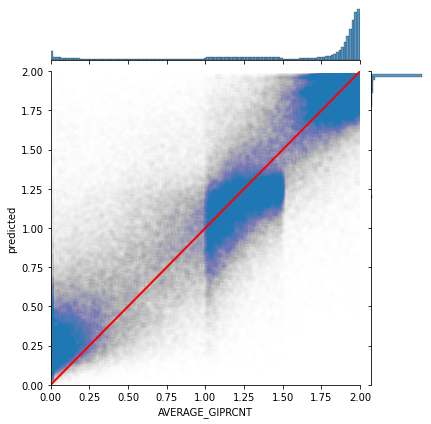

In [38]:
#new
plot=sns.jointplot(test_df.AVERAGE_GIPRCNT,test_df.predicted,alpha=0.002)
plot.ax_joint.set_xlim(0,2)
plot.ax_joint.set_ylim(0,2)
plot.ax_joint.plot([0,2], [0,2], 'r', linewidth = 2)
plot.savefig('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_CellLine/221108_NCI60_split_by_CellLine_full.pdf')

In [41]:
NCI60_randomized_level_list=[]
scale=0.1
for i in range(int(2/scale)):
    NCI60_randomized_level_df=test_df[(test_df.AVERAGE_GIPRCNT>i*scale)*(test_df.AVERAGE_GIPRCNT<(i+1)*scale)]
    NCI60_randomized_level_list.append(NCI60_randomized_level_df)
len_min=min([len(df) for df in NCI60_randomized_level_list])
NCI60_randomized_level_list_new=[]
for df in NCI60_randomized_level_list:
    scale_each=len_min/len(df)
    df_new=df.sample(frac=scale_each)
    NCI60_randomized_level_list_new.append(df_new)
NCI60_balanced=pd.concat(NCI60_randomized_level_list_new)

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


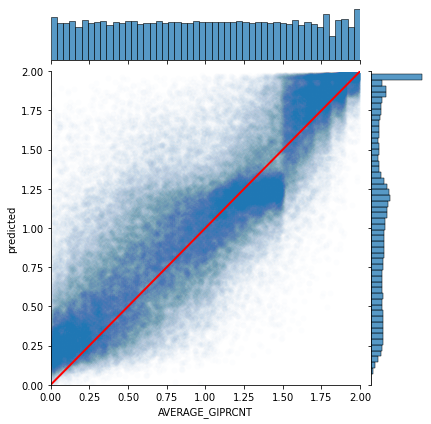

In [42]:
#new_scaled
plot=sns.jointplot(NCI60_balanced.AVERAGE_GIPRCNT,NCI60_balanced.predicted,alpha=0.01)
plot.ax_joint.set_xlim(0,2)
plot.ax_joint.set_ylim(0,2)
plot.ax_joint.plot([0,2], [0,2], 'r', linewidth = 2)
plot.savefig('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_CellLine/221108_NCI60_Split_by_CellLine_scaled.pdf')

In [44]:
model_parameter=Model(inputs=model2.inputs,outputs=[model2.get_layer('y_max').output,model2.get_layer('y_min').output,model2.get_layer('IC50').output,model2.get_layer('slope').output])

In [45]:
test_idx=test_generator.indexes
test_parameter=model_parameter.predict_generator(test_generator)
test_y_max=[x[0] for x in test_parameter[0]]
test_y_min=[x[0] for x in test_parameter[1]]
test_IC50=[x[0] for x in test_parameter[2]]
test_slope=[x[0] for x in test_parameter[3]]

In [46]:
test_idx_df=pd.DataFrame({'idx':test_Response_list})
test_idx_new=test_idx_df.iloc[test_idx].idx.values
test_df=NCI60_filtered.iloc[test_idx_new]
test_df=test_df.iloc[0:len(predicted_tmp)]

In [47]:
test_df['y_max_predicted']=test_y_max
test_df['y_min_predicted']=test_y_min
test_df['IC50_predicted']=test_IC50
test_df['slope_predicted']=test_slope

In [48]:
def response(x,y_max,y_min,IC50,slope):
    return (y_min+((y_max-y_min)/(1+np.exp(slope*(x-IC50)))))

#The function for the response curve

In [49]:
test_df['predicted_from_parameter']=[response(x.CONCENTRATION,x.y_max_predicted,x.y_min_predicted,x.IC50_predicted,x.slope_predicted) for idx,x in test_df.iterrows()]

In [50]:
test_df.corr()

,NSC,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope,y_max_predicted,y_min_predicted,IC50_predicted,slope_predicted,predicted_from_parameter
NSC,1.000000,-0.009875,0.051134,0.017042,-0.151157,-0.034400,0.008165,0.098311,0.046320,-0.068064,0.047250,0.115565,0.020515,0.055035
CONCENTRATION,-0.009875,1.000000,-0.688282,-0.000180,-0.031487,-0.000615,-0.007470,0.133915,0.014755,-0.061180,0.021393,0.089925,0.028598,-0.723129
AVERAGE_GIPRCNT,0.051134,-0.688282,1.000000,0.100432,-0.039622,-0.052520,0.141040,0.249257,0.030983,-0.112830,0.150025,0.239026,-0.000546,0.940659
Viability_max,0.017042,-0.000180,0.100432,1.000000,0.007303,0.664885,-0.034199,0.144502,0.131182,-0.139263,-0.033495,0.150296,0.104706,0.042835
count,-0.151157,-0.031487,-0.039622,0.007303,1.000000,-0.038022,0.053666,-0.185382,-0.133867,0.213651,0.045274,-0.234622,-0.157689,-0.041373
y_max,-0.034400,-0.000615,-0.052520,0.664885,-0.038022,1.000000,-0.083658,-0.248374,0.014130,0.073200,-0.143158,-0.185403,0.022438,-0.078058
y_min,0.008165,-0.007470,0.141040,-0.034199,0.053666,-0.083658,1.000000,-0.189249,-0.106171,0.486571,0.696957,-0.141280,-0.645308,0.091752
IC50,0.098311,0.133915,0.249257,0.144502,-0.185382,-0.248374,-0.189249,1.000000,0.105030,-0.663024,0.031269,0.841790,0.406579,0.207049
slope,0.046320,0.014755,0.030983,0.131182,-0.133867,0.014130,-0.106171,0.105030,1.000000,-0.342722,-0.259599,0.252609,0.343058,0.024969
y_max_predicted,-0.068064,-0.061180,-0.112830,-0.139263,0.213651,0.073200,0.486571,-0.663024,-0.342722,1.000000,0.592759,-0.846081,-0.921607,-0.116383


In [51]:
test_df.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_CellLine/221107_test_df_by_parameter.csv')